In [13]:
# Imports
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


In [3]:
# Plots Loss and accuracy of the train veresus the validation data
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

# Load data


In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
    # set path to load images from a folder in google drive
    from google.colab import drive
    drive.mount('/content/drive/')
    h_path = '/content/drive/My Drive/Colab Notebooks/predicting_nails/raw_data/Nail/normal'
    d_path = '/content/drive/My Drive/Colab Notebooks/predicting_nails/raw_data/Nail/'
else:
    # set path to load images from a local folder
    h_path = os.path.join(os.path.expanduser('~'), "code", "ariannamng",
                               "predicting_nail_diseases", 'raw_data', 'Nail', 'normal')
    d_path = os.path.join(os.path.expanduser('~'), "code", "ariannamng",
                              "predicting_nail_diseases", 'raw_data', 'Nail')


Mounted at /content/drive/


In [ ]:
diseases = ['beau_s line', 'black line', 'clubbing', 'mees_ line', 'onycholysis', 'terry_s nail', 'white spot']
X_d = []
y_d = []
X = []
y = []

# Load the healthy nails == 0
for f in os.listdir(h_path):
        img = Image.open(os.path.join(h_path, f))
        foo = img.resize((256,256))
        X.append(np.array(foo))
        y.append(0)

# Load the diseased nails == 1
for disease in diseases:
    d_path = os.path.join(d_path, disease)

    for f in os.listdir(d_path):
            img = Image.open(os.path.join(d_path, f))
            foo = img.resize((256,256))
            X_d.append(np.array(foo))
            y_d.append(1)

# Preprocessing

In [ ]:
# Shuffeling
c = list(zip(X_d, y_d))
np.random.shuffle(c)
X_d, y_d = zip(*c)

X = X + list(X_d[:len(X)])
y = y + list(y_d[:len(y)])

d = list(zip(X, y))
np.random.shuffle(d)
X, y = zip(*d)
X = np.array(X)
y = np.array(y)

In [6]:
# split data in test, val, train and preprocess data
ratio_train = 0.6
ratio_val = 0.2
len_train = int(X.shape[0]*ratio_train)
len_val = int(X.shape[0]*ratio_val)

X_train_processed = X[:len_train]/ 255. - 0.5
X_val_processed = X[len_train:(len_train+len_val)]/ 255. - 0.5
X_test_processed = X[(len_train+len_val):X.shape[0]]/ 255. - 0.5

y_train = y[:len_train]
y_val = y[len_train:(len_train+len_val)]
y_test = y[(len_train+len_val):X.shape[0]]

# TRANSFER LEARNING

In [7]:
# Compile the model as a binary classification model

def compile_model_tf(model):
    '''return a compiled model for the baseline'''
    adam = Adam(learning_rate = 0.0001)

    model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    return model

In [18]:
# Initialize and compile a model for a transfer learning

def build_model(base_model):
      '''instanciate and return the CNN architecture'''
      base_model.trainable = False
      flattening_layer = layers.Flatten()
      dense_layer = layers.Dense(500, activation='relu')
      drop_out = layers.Dropout(0.5)
      prediction_layer = layers.Dense(1, activation='sigmoid')

      model = Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      drop_out
      prediction_layer
      ])
      return compile_model_tf(model)

# Data augmentation

In [9]:
# Add Data Augmentation if your model is overfitting
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
aug.fit(X_train_processed)

train_flow = aug.flow(X_train_processed, y_train, batch_size=16)
val_flow = aug.flow(X_val_processed, y_val, batch_size=16)

# VGG16 model

In [ ]:
# Loads the VGG16 model
def load_VGG16_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train_processed.shape[1:4])
    return model

In [ ]:
# Fit the VGG16 model on the train data
es = EarlyStopping(patience = 5)
VGG16_model = build_model(load_VGG16_model())

history_VGG16 = VGG16_model.fit(
  train_flow,
  validation_data = val_flow,
  epochs = 100,
  batch_size = 32,
  verbose = 0,
  callbacks = [es]
)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

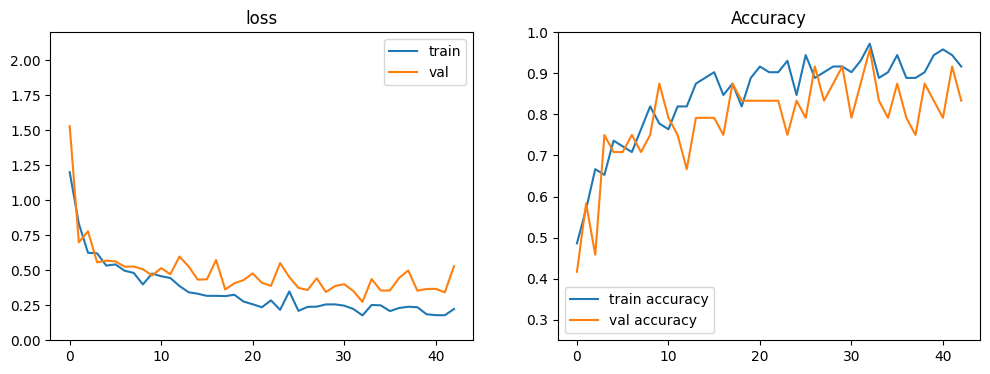

In [ ]:
# Plot Loss and accuracy of the VGG16 model
plot_history(history_VGG16, title='VGG16', axs=None, exp_name="")

In [ ]:
# Evaluate the VGG16 model using the test data
VGG16_model.evaluate(X_test_processed, y_test, verbose=0)

[0.34628280997276306, 0.9583333134651184]

# VGG19 Model

In [ ]:
# Loads the VGG19 model
def load_VGG19_model():
    model = VGG19(weights="imagenet", include_top=False, input_shape=X_train_processed.shape[1:4])
    return model

In [ ]:
# Fit the VGG19 model on the train data
es = EarlyStopping(patience = 5)
VGG19_model = build_model(load_VGG16_model())

history_VGG19 = VGG19_model.fit(
  train_flow,
  validation_data = val_flow,
  epochs = 100,
  batch_size = 32,
  verbose = 0,
  callbacks = [es]
)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

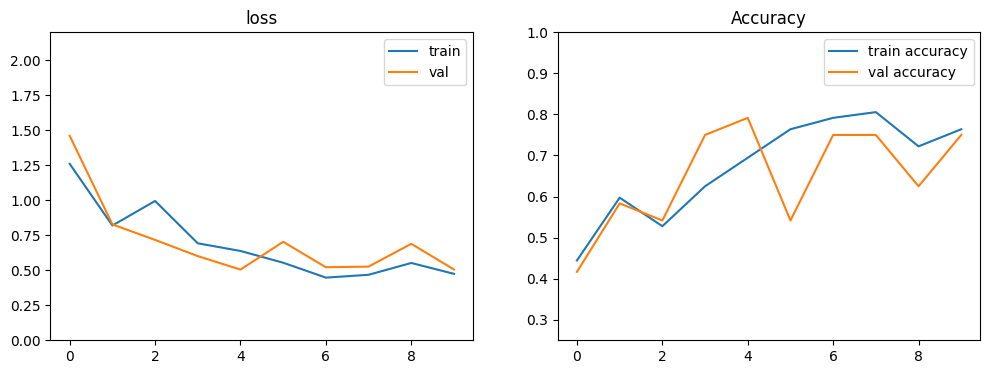

In [ ]:
# Plot Loss and accuracy of the VGG19 model
plot_history(history_VGG19, title='VGG19', axs=None, exp_name="")

In [ ]:
# Evaluate the VGG16 model using the test data
VGG19_model.evaluate(X_test_processed, y_test, verbose=0)

[0.5657753348350525, 0.6666666865348816]

# ResNet50

In [19]:
# Loads the ResNet50 model
def load_ResNet50_model():
    model = ResNet50(weights="imagenet", include_top=False, input_shape=X_train_processed.shape[1:4])
    return model

In [20]:
# Fit the ResNet50 model on the train data
es = EarlyStopping(patience = 10)
ResNet50_model = build_model(load_ResNet50_model())

history_ResNet50 = ResNet50_model.fit(
 train_flow,
  validation_data = val_flow,
  epochs = 100,
  batch_size = 32,
  verbose = 0,
  callbacks = [es]
)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

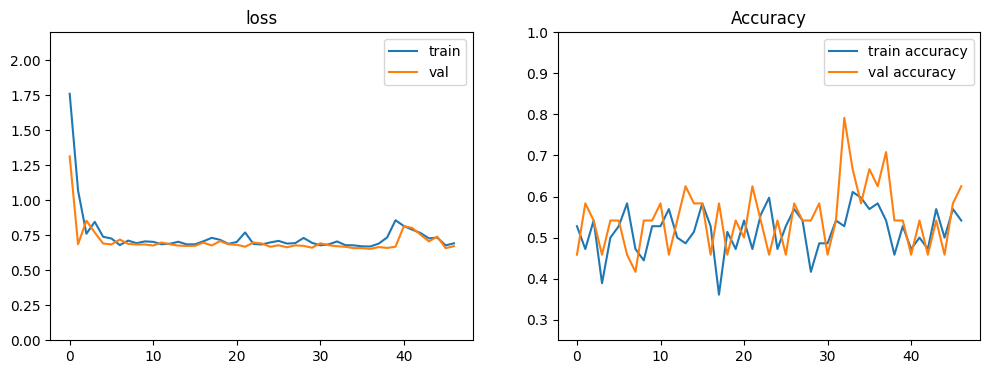

In [21]:
# Plot Loss and accuracy of the ResNet50 model
plot_history(history_ResNet50, title='ResNet50', axs=None, exp_name="")

In [ ]:
# Evaluate the ResNet50 model using the test data
ResNet50_model.evaluate(X_test_processed, y_test, verbose=0)

[0.7244213223457336, 0.5833333134651184]